In [1]:
import pandas as pd
import os
import numpy as np
from m3inference.utils import get_lang

In [2]:
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetTokenizer, XLNetForSequenceClassification, XLNetConfig
from transformers import BertForSequenceClassification, BertTokenizer, BertConfig

import torch
import torch.optim as optim

from fastai import *
from fastai.text import *
from fastai.callbacks import *

04/20/2020 17:50:19 - INFO - transformers.file_utils -   PyTorch version 1.4.0 available.
04/20/2020 17:50:20 - INFO - transformers.file_utils -   TensorFlow version 2.1.0 available.


In [3]:
import fastai
import transformers
print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)

fastai version : 1.0.60
transformers version : 2.8.0


In [4]:
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.classes.segmenter import Segmenter
from ekphrasis.dicts.emoticons import emoticons
from ekphrasis.dicts.noslang.slangdict import slangdict
import re

text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user', 'time', 'date','number'],
    # terms that will be annotated
    annotate=['hashtag', 'allcaps', 'elongated', 'repeated', 'emphasis', 'censored'],
    fix_html=True,  # fix HTML tokens
    
    # corpus from which the word statistics are going to be used
    # for word segmentation 
    segmenter="twitter_2018", 
    
    # corpus from which the word statistics are going to be used 
    # for spell correction
    corrector="twitter_2018", 
    
    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=True,  # spell correction for elongated words
    spell_correction=True,
    
    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    
    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons, slangdict]
    )

segmenter=Segmenter(corpus="twitter_2018")

def preprocess(text):
    text = text.lower()
    text = re.sub(r"\.{3}", ".", text)
    text = re.sub(",", " ", text)
    text = re.sub(":", "", text)
    text = re.sub("@ ", "@", text)
    text = re.sub("# ", "#", text)
    text = re.sub('\S*@\S*\s?', '', text)
    text = re.sub(r"\"", "", text)
    text = re.sub("\'", "", text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r'\w*pic.twitter.co\w*', '', text)
    text = re.sub(r'\w*twitter.co\w*', '', text)
    text = re.sub(r'\w*twitter.com\w*', '', text)
    text = re.sub(r"./\S+", "", text)
    text = re.sub(r"@ \S+", "", text)
    text = re.sub(r"#\S+", "", text)
    text = re.sub(r'\n+', " ", text)
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"<.*?>", "", text)
    text = re.sub("co vid", "covid", text)
    text = re.sub(r"\ss\s", " 's ", text)
    text = re.sub(r"\sm\s", " 'm ", text)
    text = re.sub(r"\sll\s", " 'll ", text)
    text = re.sub(r"\st\s", " 't ", text)
    text = re.sub(r"\sd\s", " 'd ", text)
    text = re.sub(r"\svir\s", " virus ", text)
    text = re.sub("rt", "", text)
    text = re.sub(r"\s+", " ", text)
    if get_lang(text) == 'en':
        return text.strip()
    else:
        return np.nan

Reading twitter_2018 - 1grams ...
Reading twitter_2018 - 2grams ...


/home/viet/anaconda3/lib/python3.7/site-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))
/home/viet/anaconda3/lib/python3.7/site-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


Reading twitter_2018 - 1grams ...
Reading twitter_2018 - 1grams ...
Reading twitter_2018 - 2grams ...


In [5]:
data_train = pd.DataFrame(columns=['id','truth','text'])
idx = 0

for data_file in sorted(os.listdir('./semeval')):
    if '2017' not in data_file and data_file.endswith('.txt'):
        print(data_file)
        data = open('./semeval/'+data_file,'r').readlines()
        for line in data:
            try:
                split = line.split('\t')
                data_train.loc[idx, 'id'] = split[0]
                data_train.loc[idx, 'truth'] = split[1]
                data_train.loc[idx, 'text'] = split[2]
                idx +=1
            except Exception as e:
                print(e)
                continue
                
print(len(data_train))

twitter-2013dev-A.txt
twitter-2013test-A.txt
twitter-2013train-A.txt
twitter-2014sarcasm-A.txt
twitter-2014test-A.txt
twitter-2015test-A.txt
twitter-2015train-A.txt
twitter-2016dev-A.txt
twitter-2016devtest-A.txt
twitter-2016test-A.txt
list index out of range
twitter-2016train-A.txt
50334


In [6]:
data_train['processed'] = np.nan
data_train['label'] = np.nan
label_dict = {'negative':'0','neutral':'1','positive':'2'}

for idx,row in data_train.iterrows():
    tweet = row['text']
    tweet = tweet.encode('ascii', 'ignore').decode('utf-8')
    tokens = text_processor.pre_process_doc(tweet)
#     tokens = [segmenter.segment(t) for t in tokens]
    text = " ".join(tokens)
    processed = preprocess(text)
    data_train.loc[idx,'processed'] = processed
    data_train.loc[idx,'label'] = label_dict[row['truth']]
    
data_train = data_train[data_train['processed'].notna()]
print(len(data_train))
data_train.head(10)
# data_train.to_csv('xlnet_data.csv')

50320


,id,truth,text,processed,label
0,260097528899452929,neutral,Won the match #getin . Plus\u002c tomorrow is ...,won the match get in . plus \ u002c tomorrow i...,1
1,263791921753882624,neutral,Some areas of New England could see the first ...,some areas of new england could see the first ...,1
2,264194578381410304,negative,@francesco_con40 2nd worst QB. DEFINITELY Tony...,2 and worst qb . definitely tony romo . the ma...,0
3,264041328420204544,neutral,#Thailand Washington - US President Barack Oba...,thailand washington - us president barack obam...,1
4,263816256640126976,neutral,Did y\u2019all hear what Tony Romo dressed up ...,did y \ u2019all hear what tony romo dressed u...,1
5,263722278712393728,positive,Tim Tebow may be availible ! Wow Jerry \u002c ...,tim tebow may be availible ! wow jerry \ u002c...,2
6,262936443171778560,positive,@mariakaykay aga tayo tomorrow ah. :) Good nig...,aga tayo tomorrow ass hole . good night \ u002...,2
7,260486470828171265,neutral,Tina Fey & Amy Poehler are hosting the Golden ...,tina fey & amy poehler are hosting the golden ...,1
8,262968617233162240,positive,Lunch from my new Lil spot ...THE COTTON BOWL ...,lunch from my new little spot . the cotton bow...,2
9,263790847424880641,positive,SNC Halloween Pr. Pumped. Let\u2019s work it f...,snc halloween pr . pumped . let \ u2019s work ...,2


In [7]:
print(data_train.loc[0,'processed'])

won the match get in . plus \ u002c tomorrow is a very busy day \ u002c with awareness day \ u2019s and debates . gulp . debates .


In [8]:
data_test = pd.DataFrame(columns=['id','truth','text'])

idx=0
data = open('./semeval/SemEval2017-task4-test.subtask-A.english.txt','r').readlines()
for line in data:
    try:
        split = line.split('\t')
        data_test.loc[idx, 'id'] = split[0]
        data_test.loc[idx, 'truth'] = split[1]
        data_test.loc[idx, 'text'] = split[2]
        idx +=1
    except Exception as e:
        print(e)
        continue
                
print(len(data_test))

12284


In [9]:
data_test['processed'] = np.nan
data_test['label'] = np.nan

for idx,row in data_test.iterrows():
    tweet = row['text']
    tweet = tweet.encode('ascii', 'ignore').decode('utf-8')
    tokens = text_processor.pre_process_doc(tweet)
#     tokens = [segmenter.segment(t) for t in tokens]
    text = " ".join(tokens)
    processed = preprocess(text)
    data_test.loc[idx,'processed'] = processed
    data_test.loc[idx,'label'] = label_dict[row['truth']]
    
data_test = data_test[data_test['processed'].notna()]
print(len(data_test))
data_test.head(10)
# data_test.to_csv('xlnet_data.csv')

12218


,id,truth,text,processed,label
0,801989080477154944,neutral,#ArianaGrande Ari By Ariana Grande 80% Full ht...,ariana grande ari by ariana grande full singer...,1
1,801989272341453952,positive,Ariana Grande KIIS FM Yours Truly CD listening...,ariana grande kiis fuck me yours truly cd list...,2
2,801990978424962944,positive,Ariana Grande White House Easter Egg Roll in W...,ariana grande white house easter egg roll in w...,2
3,801996232553963008,positive,#CD #Musics Ariana Grande Sweet Like Candy 3.4...,cd musics ariana grande sweet like candy oz ml...,2
4,801998343442407040,neutral,SIDE TO SIDE 😘 @arianagrande #sidetoside #aria...,side to side side to side ariana grande musica...,1
5,802001659970744064,positive,Hairspray Live! Previews at the Macy's Thanksg...,hairspray live ! previews at the macy 's thank...,2
6,802003380973568000,positive,#LindsayLohan Is ‘Feeling Thankful’ After Blas...,lindsay lohan is feeling thankful after blasti...,2
7,802014830467174016,neutral,I hate her but... I love her songs Dammit ._.#...,i hate her but . i love her songs dammit . _ ....,1
8,802020578609623040,neutral,Ariana Grande 【Right There ft. Big Sean】#アリアナ ...,ariana grande right there fuck that . big sean...,1
9,802021059490934016,positive,which one would you prefer to listen to for a ...,which one would you prefer to listen to for a ...,2


In [10]:
freq = np.asarray(np.unique(data_test['label'], return_counts=True)).T
print(freq)
dist = [c/sum(freq[:,1]) for c in freq[:,1]]
print(dist)

[['0' 3959]
 ['1' 5894]
 ['2' 2365]]
[0.32403011949582583, 0.48240301194958257, 0.1935668685545916]


In [11]:
MODEL_CLASSES = {
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig)
}

In [12]:
seed = 42
use_fp16 = False
bs = 16

model_type = 'roberta'
pretrained_model_name = 'roberta-base'

# model_type = 'bert'
# pretrained_model_name = 'bert-base-cased'

# model_type = 'xlnet'
# pretrained_model_name = 'xlnet-base-cased'

In [13]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [14]:
model_class.pretrained_model_archive_map.keys()

dict_keys(['roberta-base', 'roberta-large', 'roberta-large-mnli', 'distilroberta-base', 'roberta-base-openai-detector', 'roberta-large-openai-detector'])

In [15]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [16]:
seed_all(seed)

In [17]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
            tokens = [CLS] + tokens + [SEP]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
            if self.model_type in ['xlnet']:
                tokens = tokens + [SEP] +  [CLS]
            else:
                tokens = [CLS] + tokens + [SEP]
        return tokens

In [18]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

04/20/2020 17:53:06 - INFO - transformers.tokenization_utils -   loading file https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-vocab.json from cache at /home/viet/.cache/torch/transformers/d0c5776499adc1ded22493fae699da0971c1ee4c2587111707a4d177d20257a2.ef00af9e673c7160b4d41cfda1f48c5f4cba57d5142754525572a846a1ab1b9b
04/20/2020 17:53:06 - INFO - transformers.tokenization_utils -   loading file https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-merges.txt from cache at /home/viet/.cache/torch/transformers/b35e7cd126cd4229a746b5d5c29a749e8e84438b14bcdb575950584fe33207e8.70bec105b4158ed9a1747fea67a43f5dee97855c64d62b6ec3742f4cfdb5feda


In [19]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
    
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

In [20]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

In [21]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

In [22]:
tokens = transformer_tokenizer.tokenize('won the match get in . plus \ u002c tomorrow is a very busy day \ u002c with awareness day \ u2019s and debates . gulp . debates .')
print(tokens)
ids = transformer_tokenizer.convert_tokens_to_ids(tokens)
print(ids)
transformer_tokenizer.convert_ids_to_tokens(ids)

['won', 'Ġthe', 'Ġmatch', 'Ġget', 'Ġin', 'Ġ.', 'Ġplus', 'Ġ\\', 'Ġu', '002', 'c', 'Ġtomorrow', 'Ġis', 'Ġa', 'Ġvery', 'Ġbusy', 'Ġday', 'Ġ\\', 'Ġu', '002', 'c', 'Ġwith', 'Ġawareness', 'Ġday', 'Ġ\\', 'Ġu', '2019', 's', 'Ġand', 'Ġdebates', 'Ġ.', 'Ġg', 'ulp', 'Ġ.', 'Ġdebates', 'Ġ.']
[17526, 5, 914, 120, 11, 479, 2704, 44128, 1717, 19130, 438, 3859, 16, 10, 182, 3610, 183, 44128, 1717, 19130, 438, 19, 4199, 183, 44128, 1717, 10626, 29, 8, 14759, 479, 821, 31777, 479, 14759, 479]


['won',
 'Ġthe',
 'Ġmatch',
 'Ġget',
 'Ġin',
 'Ġ.',
 'Ġplus',
 'Ġ\\',
 'Ġu',
 '002',
 'c',
 'Ġtomorrow',
 'Ġis',
 'Ġa',
 'Ġvery',
 'Ġbusy',
 'Ġday',
 'Ġ\\',
 'Ġu',
 '002',
 'c',
 'Ġwith',
 'Ġawareness',
 'Ġday',
 'Ġ\\',
 'Ġu',
 '2019',
 's',
 'Ġand',
 'Ġdebates',
 'Ġ.',
 'Ġg',
 'ulp',
 'Ġ.',
 'Ġdebates',
 'Ġ.']

In [23]:
databunch = (TextList.from_df(data_train, cols='processed', processor=transformer_processor)
             .split_by_rand_pct(0.1,seed=seed)
             .label_from_df(cols= 'label')
             .add_test(data_test)
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

04/20/2020 17:53:07 - INFO - numexpr.utils -   Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
04/20/2020 17:53:07 - INFO - numexpr.utils -   NumExpr defaulting to 8 threads.


In [24]:
print('[CLS] token :', transformer_tokenizer.cls_token)
print('[SEP] token :', transformer_tokenizer.sep_token)
print('[PAD] token :', transformer_tokenizer.pad_token)
databunch.show_batch()

[CLS] token : <s>
[SEP] token : </s>
[PAD] token : <pad>


text,target
<s> Ġ2 Ġand Ġday Ġof Ġv ino om ank ad Ġu 19 Ġo di Ġh ary ana Ġ\ Ġu 002 c Ġk erala Ġ\ Ġu 002 c Ġand hra Ġ\ Ġu 002 c Ġt n Ġ\ Ġu 002 c Ġm umbai Ġ\ Ġu 002 c Ġbar oda Ġ\ Ġu 002 c Ġup Ġwon Ġtheir Ġmatches Ġagainst Ġj Ġ& Ġk Ġ\ Ġu 002 c Ġk ar Ġ\ Ġu 002 c Ġhyd,1
<s> Ġi Ġhave Ġgot Ġ1 Ġstop Ġthat Ġunit Ġback Ġro st u Ġmag get te Ġc v 31 Ġg mon roe Ġ& Ġ2 Ġand Ġunit Ġby num Ġday e Ġthinking Ġabout Ġyou Ġj ere b ko Ġdrum mond Ġi Ġhope Ġj r Ġwat che z Ġthe Ġpist ons Ġstick z Ġw Ġ/ Ġthem Ġsum Ġ. </s>,1
<s> Ġ\ Ġm onday Ġ\ Ġu 2019 s Ġ\ Ġbom ani Ġ& Ġj ones Ġ\ Ġis Ġon Ġj ordan Ġje ff erson Ġ. Ġand Ġyeah Ġ\ Ġu 002 c Ġit Ġ\ Ġu 2019 ll Ġbe Ġa Ġdo ozy Ġ\ Ġu 002 c Ġtoo Ġ. Ġ\ Ġthey Ġgive Ġus Ġweed Ġsmokers Ġa Ġbad Ġname </s>,0
<s> Ġ\ Ġu 2019 up Ġall Ġnight Ġ\ Ġu 2019 s Ġ\ Ġu 2019 Ġmay a Ġrud olph Ġ\ Ġu 2019 s aturday Ġnight Ġlive Ġ\ Ġu 2019 Ġtraining Ġ\ Ġu 2019 prep ares Ġyou Ġfor Ġanything Ġ\ Ġu 2019 Ġmay a Ġrud olph Ġ\ Ġu 002 c Ġ. Ġtelevision Ġnews </s>,1
<s> Ġlet Ġ\ Ġu 2019 s Ġjust Ġsay Ġ\ Ġu 002 c Ġi Ġcall Ġit Ġthe Ġcase y Ġ\ Ġu 2019 s Ġtr if ect a Ġ. Ġi Ġ\ Ġu 2019 ll Ġexplain Ġin Ġhom ero om Ġtomorrow Ġ. Ġafter Ġi Ġask Ġc ory Ġto Ġhome coming Ġlaughing Ġout Ġloud </s>,2


In [25]:
# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        
        # attention_mask
        # Mask to avoid performing attention on padding token indices.
        # Mask values selected in ``[0, 1]``:
        # ``1`` for tokens that are NOT MASKED, ``0`` for MASKED tokens.
        attention_mask = (input_ids!=pad_idx).type(input_ids.type()) 
        
        logits = self.transformer(input_ids,
                                  attention_mask = attention_mask)[0]   
        return logits

In [26]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 3
config.use_bfloat16 = use_fp16
print(config)

04/20/2020 17:53:23 - INFO - transformers.configuration_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-config.json from cache at /home/viet/.cache/torch/transformers/e1a2a406b5a05063c31f4dfdee7608986ba7c6393f7f79db5e69dcd197208534.a7ab0e5de2d8321d6d6a15b199110f2c99be72976b7d151423cb8d8c261a13b6
04/20/2020 17:53:23 - INFO - transformers.configuration_utils -   Model config RobertaConfig {
  "_num_labels": 2,
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bad_words_ids": null,
  "bos_token_id": 0,
  "decoder_start_token_id": null,
  "do_sample": false,
  "early_stopping": false,
  "eos_token_id": 2,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "is_encoder_decoder": false,
  "label2id": {
   

RobertaConfig {
  "_num_labels": 3,
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bad_words_ids": null,
  "bos_token_id": 0,
  "decoder_start_token_id": null,
  "do_sample": false,
  "early_stopping": false,
  "eos_token_id": 2,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "is_encoder_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings": 514,
  "min_length": 0,
  "model_type": "roberta",
  "no_repeat_ngram_size": 0,
  "num_attention_heads": 12,
  "num_beams": 1,
  "num_hidden_layers": 12,
  "num_return_sequences": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "outpu

In [27]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
# transformer_model = model_class.from_pretrained(pretrained_model_name, num_labels = 5)

custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

04/20/2020 17:53:23 - INFO - transformers.modeling_utils -   loading weights file https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-pytorch_model.bin from cache at /home/viet/.cache/torch/transformers/228756ed15b6d200d7cb45aaef08c087e2706f54cb912863d2efe07c89584eb7.49b88ba7ec2c26a7558dda98ca3884c3b80fa31cf43a1b1f23aef3ff81ba344e
04/20/2020 17:53:25 - INFO - transformers.modeling_utils -   Weights of RobertaForSequenceClassification not initialized from pretrained model: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
04/20/2020 17:53:25 - INFO - transformers.modeling_utils -   Weights from pretrained model not used in RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']


In [28]:
from fastai.callbacks import *
from torch.nn import CrossEntropyLoss
from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)
loss = CrossEntropyLoss()

recall = Recall()
precision = Precision()
learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  loss_func = loss,
                  metrics=[precision, recall, accuracy, error_rate])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Seems to not working
if use_fp16: learner = learner.to_fp16()

In [29]:
print(learner.model)

CustomTransformerModel(
  (transformer): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(i

In [30]:
# For xlnet-base-cased
if model_type in ['xlnet']:
    list_layers = [learner.model.transformer.transformer.word_embedding,
                  learner.model.transformer.transformer.layer[0],
                  learner.model.transformer.transformer.layer[1],
                  learner.model.transformer.transformer.layer[2],
                  learner.model.transformer.transformer.layer[3],
                  learner.model.transformer.transformer.layer[4],
                  learner.model.transformer.transformer.layer[5],
                  learner.model.transformer.transformer.layer[6],
                  learner.model.transformer.transformer.layer[7],
                  learner.model.transformer.transformer.layer[8],
                  learner.model.transformer.transformer.layer[9],
                  learner.model.transformer.transformer.layer[10],
                  learner.model.transformer.transformer.layer[11],
                  learner.model.transformer.sequence_summary]

# For roberta-base
if model_type in ['roberta']:
    list_layers = [learner.model.transformer.roberta.embeddings,
                  learner.model.transformer.roberta.encoder.layer[0],
                  learner.model.transformer.roberta.encoder.layer[1],
                  learner.model.transformer.roberta.encoder.layer[2],
                  learner.model.transformer.roberta.encoder.layer[3],
                  learner.model.transformer.roberta.encoder.layer[4],
                  learner.model.transformer.roberta.encoder.layer[5],
                  learner.model.transformer.roberta.encoder.layer[6],
                  learner.model.transformer.roberta.encoder.layer[7],
                  learner.model.transformer.roberta.encoder.layer[8],
                  learner.model.transformer.roberta.encoder.layer[9],
                  learner.model.transformer.roberta.encoder.layer[10],
                  learner.model.transformer.roberta.encoder.layer[11],
                  learner.model.transformer.roberta.pooler]
    
if model_type in ['bert']:
    list_layers = [learner.model.transformer.bert.embeddings,
                  learner.model.transformer.bert.encoder.layer[0],
                  learner.model.transformer.bert.encoder.layer[1],
                  learner.model.transformer.bert.encoder.layer[2],
                  learner.model.transformer.bert.encoder.layer[3],
                  learner.model.transformer.bert.encoder.layer[4],
                  learner.model.transformer.bert.encoder.layer[5],
                  learner.model.transformer.bert.encoder.layer[6],
                  learner.model.transformer.bert.encoder.layer[7],
                  learner.model.transformer.bert.encoder.layer[8],
                  learner.model.transformer.bert.encoder.layer[9],
                  learner.model.transformer.bert.encoder.layer[10],
                  learner.model.transformer.bert.encoder.layer[11],
                  learner.model.transformer.bert.pooler]

In [31]:
learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')
print(learner.layer_groups)

Learner split in 14 groups
[Sequential(
  (0): Embedding(50265, 768, padding_idx=1)
  (1): Embedding(514, 768, padding_idx=1)
  (2): Embedding(1, 768)
  (3): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (4): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2): Linear(in_features=768, out_features=768, bias=True)
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=768, out_features=768, bias=True)
  (5): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (6): Dropout(p=0.1, inplace=False)
  (7): Linear(in_features=768, out_features=3072, bias=True)
  (8): Linear(in_features=3072, out_features=768, bias=True)
  (9): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (10): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2)

In [32]:
learner.save('./untrain.pth')

In [33]:
seed_all(seed)
learner.load('./untrain.pth');

In [34]:
learner.freeze_to(-1)

In [35]:
learner.summary()

CustomTransformerModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [93, 768]            38,603,520 False     
______________________________________________________________________
Embedding            [93, 768]            394,752    False     
______________________________________________________________________
Embedding            [93, 768]            768        False     
______________________________________________________________________
LayerNorm            [93, 768]            1,536      False     
______________________________________________________________________
Dropout              [93, 768]            0          False     
______________________________________________________________________
Linear               [93, 768]            590,592    False     
______________________________________________________________________
Linear               [93, 768]            590,592    False     
_______________________________________

In [36]:
learner.lr_find()

epoch,train_loss,valid_loss,precision,recall,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.45E-05
Min loss divided by 10: 5.25E-06


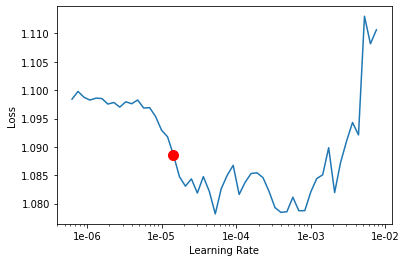

In [37]:
learner.recorder.plot(skip_end=10,suggestion=True)

epoch,train_loss,valid_loss,precision,recall,accuracy,error_rate,time
0,0.980538,0.995073,nan,0.414335,0.528617,0.471383,01:09


/home/viet/anaconda3/lib/python3.7/site-packages/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


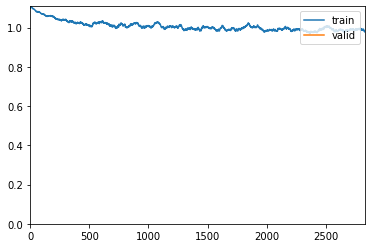

In [38]:
learner.fit_one_cycle(1, max_lr=2e-05,moms=(0.8,0.7))

In [39]:
learner.save('./first_cycle.pth')

In [40]:
seed_all(seed)
learner.load('./first_cycle.pth');

In [41]:
lr = 1e-05

In [42]:
learner.freeze_to(-2)

epoch,train_loss,valid_loss,precision,recall,accuracy,error_rate,time
0,0.743601,0.709448,0.655585,0.638163,0.671304,0.328696,01:19


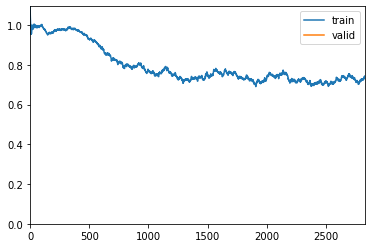

In [43]:
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [44]:
learner.save('./second_cycle.pth')

In [45]:
seed_all(seed)
learner.load('./second_cycle.pth');

In [46]:
learner.freeze_to(-3)

epoch,train_loss,valid_loss,precision,recall,accuracy,error_rate,time
0,0.713586,0.676967,0.676827,0.666703,0.689189,0.310811,01:31


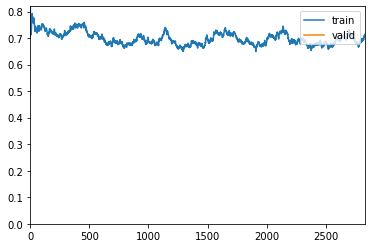

In [47]:
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [48]:
learner.save('./third_cycle.pth')

In [49]:
seed_all(seed)
learner.load('./third_cycle.pth');

In [50]:
learner.unfreeze()

epoch,train_loss,valid_loss,precision,recall,accuracy,error_rate,time
0,0.646181,0.659831,0.685325,0.721707,0.703100,0.296900,04:11
1,0.575520,0.620670,0.711350,0.722020,0.724364,0.275636,04:23


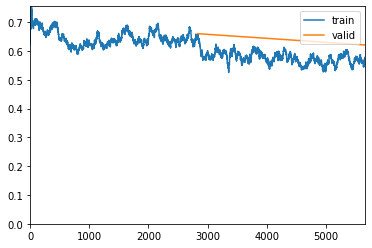

In [51]:
learner.fit_one_cycle(2, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [52]:
learner.predict("scientists  you should wash your hands because of coronavirus . people  i am going   to stop flying   hoard masks   work from home & t")

(Category 0, tensor(0), tensor([0.6464, 0.2943, 0.0593]))

In [53]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    """
    the get_preds method does not yield the elements in order by default
    we borrow the code from the RNNLearner to resort the elements into their correct order
    """
    preds = learner.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in databunch.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    return preds[reverse_sampler, :]

test_preds = get_preds_as_nparray(DatasetType.Test)

In [54]:
data_test['prediction'] = np.argmax(test_preds,axis=1)

In [55]:
data_test.head(10)

,id,truth,text,processed,label,prediction
0,801989080477154944,neutral,#ArianaGrande Ari By Ariana Grande 80% Full ht...,ariana grande ari by ariana grande full singer...,1,1
1,801989272341453952,positive,Ariana Grande KIIS FM Yours Truly CD listening...,ariana grande kiis fuck me yours truly cd list...,2,2
2,801990978424962944,positive,Ariana Grande White House Easter Egg Roll in W...,ariana grande white house easter egg roll in w...,2,1
3,801996232553963008,positive,#CD #Musics Ariana Grande Sweet Like Candy 3.4...,cd musics ariana grande sweet like candy oz ml...,2,1
4,801998343442407040,neutral,SIDE TO SIDE 😘 @arianagrande #sidetoside #aria...,side to side side to side ariana grande musica...,1,2
5,802001659970744064,positive,Hairspray Live! Previews at the Macy's Thanksg...,hairspray live ! previews at the macy 's thank...,2,1
6,802003380973568000,positive,#LindsayLohan Is ‘Feeling Thankful’ After Blas...,lindsay lohan is feeling thankful after blasti...,2,2
7,802014830467174016,neutral,I hate her but... I love her songs Dammit ._.#...,i hate her but . i love her songs dammit . _ ....,1,0
8,802020578609623040,neutral,Ariana Grande 【Right There ft. Big Sean】#アリアナ ...,ariana grande right there fuck that . big sean...,1,1
9,802021059490934016,positive,which one would you prefer to listen to for a ...,which one would you prefer to listen to for a ...,2,1


In [56]:
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
pred = [int(p) for p in data_test['prediction']]
pred = np.array(pred)
truth = [int(l) for l in data_test['label']]
truth = np.array(truth)

print(classification_report(pred,truth, digits=4))
print(confusion_matrix(pred,truth))
print(accuracy_score(pred,truth))

              precision    recall  f1-score   support

           0     0.8373    0.7929    0.8145      4181
           1     0.7878    0.8113    0.7993      5723
           2     0.7966    0.8142    0.8053      2314

    accuracy                         0.8055     12218
   macro avg     0.8072    0.8061    0.8064     12218
weighted avg     0.8064    0.8055    0.8057     12218

[[3315  843   23]
 [ 622 4643  458]
 [  22  408 1884]]
0.8055328204288754


In [57]:
topics = ['Global News','Political Discussion','Social Distancing','School Closing','Local News','China Controversy']

In [58]:
student_sentiments = []
general_sentiments = []

for i in range(len(topics)):
    print(topics[i])
    student_tweets = open('student_tweets_{}.txt'.format('_'.join(topics[i].split(' '))), 'r').readlines()
#     print(len(student_tweets))
    
    student_pred = []
    for tweet in student_tweets:
        tweet = tweet.encode('ascii', 'ignore').decode('utf-8')
        tokens = text_processor.pre_process_doc(tweet)
        text = " ".join(tokens)
        processed = preprocess(text)
        pred = learner.predict(processed)
        _, pred = torch.max(pred[2],0)
        student_pred.append(pred.item())
    student_freq = np.asarray(np.unique(student_pred, return_counts=True)).T
    student_dist = [c/sum(student_freq[:,1]) for c in student_freq[:,1]]
    student_sentiments.append(student_dist)
    
    general_tweets = open('general_tweets_{}.txt'.format('_'.join(topics[i].split(' '))), 'r').readlines()
#     print(len(student_tweets))
    general_pred = []

    for tweet in general_tweets:
        tweet = tweet.encode('ascii', 'ignore').decode('utf-8')
        tokens = text_processor.pre_process_doc(tweet)
        text = " ".join(tokens)
        processed = preprocess(text)
        pred = learner.predict(processed)
        _, pred = torch.max(pred[2],0)
        general_pred.append(pred.item())
    general_freq = np.asarray(np.unique(general_pred, return_counts=True)).T
    general_dist = [c/sum(general_freq[:,1]) for c in general_freq[:,1]]
    general_sentiments.append(general_dist)
    
student_sentiments = np.array(student_sentiments)
general_sentiments = np.array(general_sentiments)
print(student_sentiments)
print(general_sentiments)

Global News
Political Discussion
Social Distancing
School Closing
Local News
China Controversy
[[0.416667 0.550314 0.033019]
 [0.353774 0.558176 0.08805 ]
 [0.382075 0.503145 0.11478 ]
 [0.388265 0.566792 0.044944]
 [0.394057 0.53876  0.067183]
 [0.734432 0.227106 0.038462]]
[[0.278577 0.693057 0.028366]
 [0.325312 0.546506 0.128181]
 [0.236842 0.622998 0.14016 ]
 [0.338373 0.608351 0.053276]
 [0.261572 0.660544 0.077884]
 [0.596008 0.330351 0.073641]]


(0, 1.2)

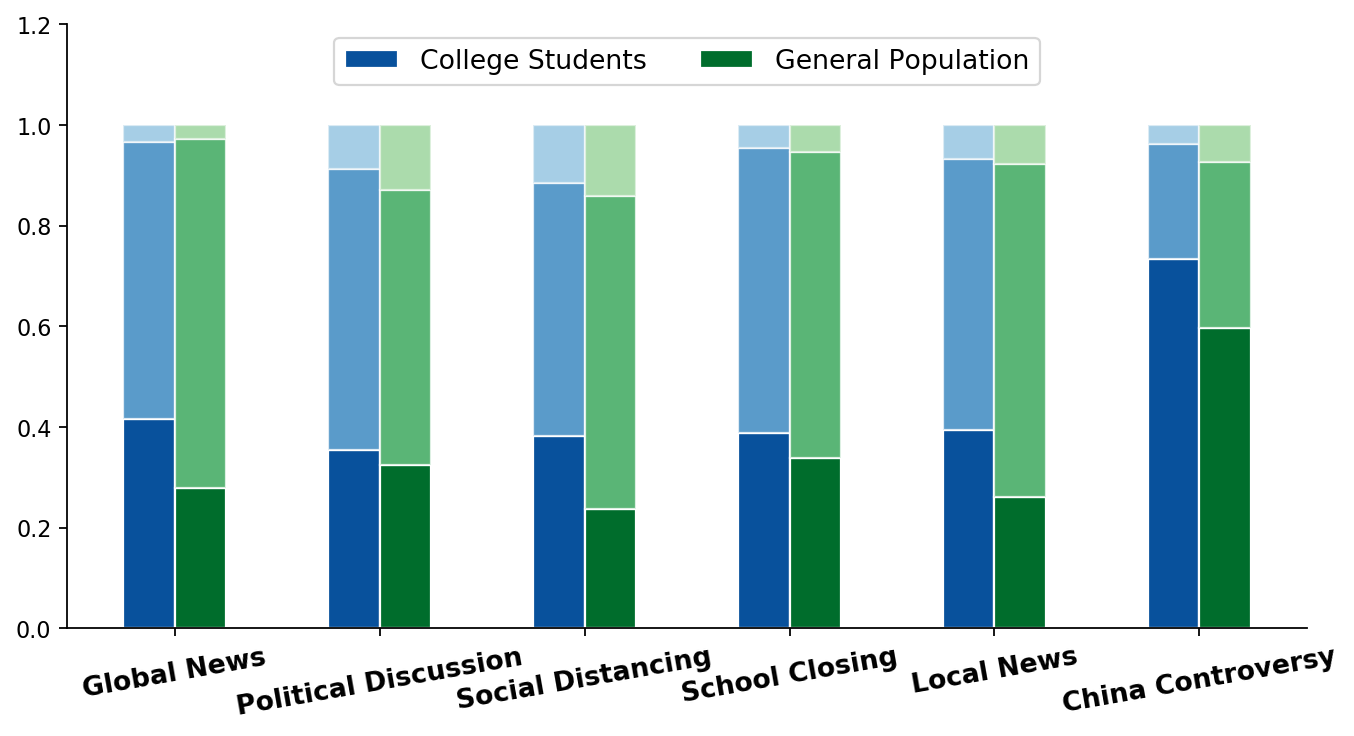

In [59]:
from bokeh.palettes import Blues, Greens
fig, ax = plt.subplots(figsize=(10,5), sharey=True, dpi=160)
student_colors = np.array(Blues[5][:3])
general_colors = np.array(Greens[5][:3])

barWidth = 0.25
r1 = np.arange(6)
r2 = [x + barWidth for x in r1]

for i in range(len(topics)):
    pos = student_sentiments[i,:][2]
    neu = student_sentiments[i,:][1]
    neg = student_sentiments[i,:][0]
    ax.bar(r1[i], neg, color=student_colors[0], width=barWidth, edgecolor='white', label='Negative')
    ax.bar(r1[i], neu, bottom=neg, color=student_colors[1], width=barWidth, edgecolor='white', label='Neutral', alpha=0.8)
    ax.bar(r1[i], pos, bottom=neg+neu, color=student_colors[2], width=barWidth, edgecolor='white', label='Positive', alpha=0.6)
    
for i in range(len(topics)):
    pos = general_sentiments[i,:][2]
    neu = general_sentiments[i,:][1]
    neg = general_sentiments[i,:][0]
    ax.bar(r2[i], neg, color=general_colors[0], width=barWidth, edgecolor='white', label='Negative')
    ax.bar(r2[i], neu, bottom=neg, color=general_colors[1], width=barWidth, edgecolor='white', label='Neutral', alpha=0.8)
    ax.bar(r2[i], pos, bottom=neg+neu, color=general_colors[2], width=barWidth, edgecolor='white', label='Positive', alpha=0.6)
    
# plt.xlabel('Topic', fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks([r + barWidth/2 for r in range(6)], topics, rotation=10, fontsize=12, fontweight='bold')
custom_patches = [Patch(facecolor=student_colors[0], edgecolor='w', label='College Students'),
                  Patch(facecolor=general_colors[0], edgecolor='w', label='General Population')]
ax.legend(handles=custom_patches, loc='upper center', fontsize=12, ncol=2)
ax.set_ylim(0, 1.2)

In [60]:
# topic = 'China_Controversy'
# tweets = open('student_tweets_{}.txt'.format(topic), 'r').readlines()

# sentiments = []
# for tweet in tweets:
#     tweet = tweet.encode('ascii', 'ignore').decode('utf-8')
#     tokens = text_processor.pre_process_doc(tweet)
#     text = " ".join(tokens)
#     processed = preprocess(text)
#     pred = learner.predict(processed)
#     _, pred = torch.max(pred[2],0)
#     sentiments.append(pred.item())

In [61]:
# print(len(tweets))
# print(len(sentiments))

In [62]:
# with open('student_sentiments_{}.txt'.format(topic), 'w') as f:
#     for s in sentiments:
#         f.write(str(s)+'\n')